### Imports

In [45]:
import cv2
import ast
import time

import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sympy import Interval, Union
from tqdm import tqdm, trange
import seaborn as sns

from PIL import ImageFont, ImageDraw, Image

from helpers.limbus_detection import detect_circle
from helpers.bioniko_detection import detect_bioniko
from helpers.orientation_detection import detect_markers_entropy, detect_markers_hu_moments
from helpers.keypoint_based_tracking import estimate_transform, get_transform_info
from helpers.misc import get_avg_laplacian, get_in_out_intensity_diff, get_mean_intensity, \
    jiggle_circle, tighten_circle
from helpers.view_detection import get_view_mask


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### helper functions

In [2]:
def extract_annotations(csv_path, total_frames, label_name, fps=30):
    data = pd.read_csv(csv_path)
    data['points'] = data['points'].apply(lambda x: np.array(ast.literal_eval(x)))
    data['frames'] = data['frames'].apply(lambda x: np.array(ast.literal_eval(x)))
    
    annotations = []
    frames = []
    full_frame_intervals = []
    for _, row in data[data.label_name == label_name].iterrows():
        annotations.append(row['points'])
        frames.append(row['frames'])
        full_frame_intervals.append(Interval(row['frames'][0], row['frames'][-1]))
        
    full_frame_union = Union(*full_frame_intervals)
        
    annotations = np.concatenate(annotations)
    frames = np.concatenate(frames)
    
    sort_index = np.argsort(frames)
    
    annotations = annotations[sort_index]
    frames = frames[sort_index]
    
    annotations_per_frame = []
    cur_index = 0
    for frame in trange(total_frames):
        if cur_index < (len(annotations) - 1) and (frame/30) >= frames[cur_index + 1]:
            cur_index += 1
        
        if full_frame_union.contains(frame/30):
            annotations_per_frame.append(annotations[cur_index])
        else:
            annotations_per_frame.append(None)
        
    return annotations_per_frame
    

In [3]:
def get_orientation(circle, zero_point):
    a = np.array(zero_point)
    b = np.array([circle[0], circle[1]])
    c = a - b
    
    alpha = np.arctan2(c[1], c[0])
    
    if alpha < 0:
        alpha = alpha + 2*np.pi
    
    alpha = 2*np.pi - alpha
    
    return alpha

In [4]:
def get_line_points(circle, zero_point):
    a = np.array(zero_point)
    b = np.array([circle[0], circle[1]])
    c = a - b
    c = c / np.linalg.norm(c)
    c = c * circle[2]
    
    start = b
    end = b + c 
    
    return [round(start[0]), round(start[1])], [round(end[0]), round(end[1])]

In [5]:
def draw_circle(img, circle, color=(0,255,0)):
    center = (round(circle[0]),round(circle[1]))
    radius = round(circle[2])
    cv2.circle(img, center, radius, color)

In [6]:
def draw_axis(img, circle, zero_point, color=(0,255,0)):
    start, end = get_line_points(circle, zero_point)
    cv2.line(img, start, end, color)

In [7]:
def numpy_array_robust(l):
    size = None
    for el in l:
        if el is not None:
            size = len(el)
            break
            
    return np.array([
        (
            el
            if el is not None 
            else np.array(size*[np.nan])
        )
        for el in l
    ])

#### displaying the ground truth

In [20]:
cap = cv2.VideoCapture('data/artificial/procedure5_lofi.mkv')
annotation_path = 'data/annotations/6238-first-4.csv'

print('extracting circles')
ground_truth_circles = extract_annotations(annotation_path, int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), 'limbus')
ground_truth_circles = numpy_array_robust(ground_truth_circles)
print('extracting orientation')
ground_truth_zero_points = extract_annotations(annotation_path, int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), 'orientation')
ground_truth_zero_points = numpy_array_robust(ground_truth_zero_points)

extracting circles


100%|███████████████████████████████████████| 3873/3873 [00:45<00:00, 84.67it/s]


extracting orientation


100%|██████████████████████████████████████| 3873/3873 [00:17<00:00, 216.64it/s]


In [ ]:
cap = cv2.VideoCapture('data/artificial/procedure5_lofi.mkv')
frame = 0
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break

    # hsv conversion
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:, :, 2]
    
    # visualization
    vis = cv2.cvtColor(base_value, cv2.COLOR_GRAY2BGR)
    circle = ground_truth_circles[frame]
    zero_point = ground_truth_zero_points[frame]
    if circle is not None:
        draw_circle(vis, circle)
        if zero_point is not None:
            draw_axis(vis, circle, zero_point)
#             print(180*get_orientation(circle, zero_point)/np.pi)
    else:
        cv2.putText(vis, 'no detection', (10,10), cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,255))

    cv2.imshow('result', base)
    cv2.imshow('visualization', vis)
    
    frame += 1

    if cv2.waitKey(25) == ord('q'):
        break

cap.release()
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)

#### limbus tracking: naive vs. inout

visualization (optional)

In [ ]:
cap = cv2.VideoCapture('data/artificial/procedure5_lofi.mkv')
frame = 0
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break

    # hsv conversion
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:, :, 2]
    
    # visualization
    vis = cv2.cvtColor(base_value, cv2.COLOR_GRAY2BGR)
    ground_truth_circle = ground_truth_circles[frame]
    if ground_truth_circle is not None:
        draw_circle(vis, ground_truth_circle)
    else:
        cv2.putText(vis, 'no groundtruth', (10,10), cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,255))
        
    # detection
    circle = detect_circle(
        base_value,
        validation='inout',
        validation_mode='max',
        validation_value_thresh=0.0,
        considered_ratio_s=0.1,
        circle_width_to_radius_ratio=0.059,
        min_radius_ratio=1/10,
        max_radius_ratio=1/2,
        max_processing_dim=320,
        gaussian_blur_sigma=2.3
    )
    if circle is not None:
        draw_circle(vis, circle, (255,0,0))

    cv2.imshow('result', base)
    cv2.imshow('visualization', vis)
    
    frame += 1

    if cv2.waitKey(25) == ord('q'):
        break

cap.release()
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)

computation

In [13]:
cap = cv2.VideoCapture('data/artificial/procedure5_lofi.mkv')
circles_inout = []
circles_first = []

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
pbar = tqdm(total=total_frames)
frame = 0
while cap.isOpened():
    ret, base = cap.read()
    if not ret:
        break
        
    # hsv conversion
    base_hsv = cv2.cvtColor(base, cv2.COLOR_BGR2HSV)
    base_value = base_hsv[:, :, 2]
        
    # first
    circle = detect_circle(
        base_value,
        validation='first',
        circle_width_to_radius_ratio=0.059,
        min_radius_ratio=1/10,
        max_radius_ratio=1/2,
        max_processing_dim=320,
        gaussian_blur_sigma=2.3
    )
    circles_first.append(circle)
    
    # inout
    circle = detect_circle(
        base_value,
        validation='inout',
        validation_mode='max',
        validation_value_thresh=0.0,
        considered_ratio_s=0.1,
        circle_width_to_radius_ratio=0.059,
        min_radius_ratio=1/10,
        max_radius_ratio=1/2,
        max_processing_dim=320,
        gaussian_blur_sigma=2.3
    )
    circles_inout.append(circle)
    
    pbar.update()

    if cv2.waitKey(25) == ord('q'):
        break
        
pbar.close()

cap.release()
for _ in range(10):
    cv2.destroyAllWindows()
    cv2.waitKey(1)

100%|██████████████████████████████████████▉| 3872/3873 [02:45<00:00, 23.34it/s]


In [21]:
ground_truth_circles = ground_truth_circles[:len(circles_first)]
ground_truth_zero_points = ground_truth_zero_points[:len(circles_first)]

In [15]:
circles_first = numpy_array_robust(circles_first)
circles_inout = numpy_array_robust(circles_inout)

centration & radius diffrence

In [96]:
centration_first = np.linalg.norm(circles_first[:,:2] - ground_truth_circles[:,:2], axis=1)
# TODO: normalization by radius might be better
centration_first_normalized = centration_first / (2*ground_truth_circles[:,2])

centration_inout = np.linalg.norm(circles_inout[:,:2] - ground_truth_circles[:,:2], axis=1)
# TODO: normalization by radius might be better
centration_inout_normalized = centration_inout / (2*ground_truth_circles[:,2])

radius_diff_first = np.abs(circles_first[:,2] - ground_truth_circles[:,2])
radius_diff_first_normalized = radius_diff_first / ground_truth_circles[:,2]
radius_diff_inout = np.abs(circles_inout[:,2] - ground_truth_circles[:,2])
radius_diff_inout_normalized = radius_diff_inout / ground_truth_circles[:,2]

In [98]:
df = pd.DataFrame({
    'method': len(centration_first)*['first'] + len(centration_inout)*['inout'],
    'centration': centration_first.tolist() + centration_inout.tolist(),
    'ground_truth_radius': ground_truth_circles[:,2].tolist()*2,
    'centration_normalized': centration_first_normalized.tolist() + centration_inout_normalized.tolist(),
    'radius_diff': radius_diff_first.tolist() + radius_diff_inout.tolist(),
    'radius_diff_normalized': radius_diff_first_normalized.tolist() + radius_diff_inout_normalized.tolist(),
})

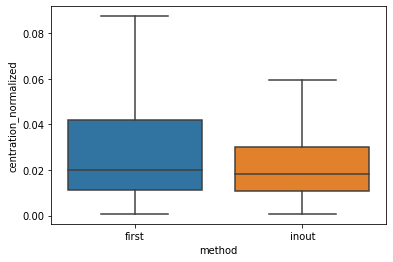

In [99]:
ax = sns.boxplot(x='method', y='centration_normalized', showfliers=False, data=df)

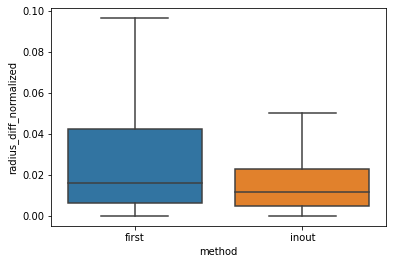

In [101]:
ax = sns.boxplot(x='method', y='radius_diff_normalized', showfliers=False, data=df)